# IF240 - Apprentissage et deep learning

## Assignment 2: CNNs for denoising 

By Aurélie Bugeau
Credits Charles Deledalle  

<font color="blue">

#### Students:  CHATAIGNER Johan and GERMON Paul

</font>

In this assignment,
we are going to consider a specific regression problem: image denoising.
We will be using deep Convolutional Neural Networks (CNNs) with PyTorch,
investigate DnCNN

We will be using a subsamples of images from the "Berkeley Segmentation Dataset and Benchmark" that can be found on Moodle.
_Note: if you wish to obtain better results and experiment further, you can download the whole dataset here. 
that are downloadable here \url{https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/resources.html#bsds500}_

This directory contains two sub-directories: `train` and `tes`,
which consist of 30 and 10 images, respectively, of either size $321 \times 481$
or $481 \times 321$.
While thousand to millions of images were required
for image classification, we can use a much smaller training set
for image denoising. This is because denoising each pixel of an image can
be seen as one regression problem. Hence, our training is in fact composed
of $30 \times 321 \times 481 \approx 31$ million samples.



_RECOMMENDATION: For this assignment, you may need to run your codes on GPU (either colaboratory or your laptop)_

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision as tv
from PIL import Image
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
#torch.cuda.current_device() #Gives informations if cuda is not available
print(device)

cpu


## 1 Creating noisy images of BSDS dataset with DataSet

Our goal is to use deep convolutional neural networks to learn the mapping $x_i \to y_i$
where $x_i$ are noisy images (our data/observations) and $y_i$ are clean images
(our labels/ground-truth).

We will consider the images of the BSDS dataset as our clean/ground-truth images: $y_i$.
For each of them, we will generate noisy versions by adding white Gaussian noise:
$x_i = y_i + w_i$ where $w_i$ is an image where each pixel is an independent realization
of a zero-mean Gaussian distribution with standard deviation $\sigma=30$.
Since images have different sizes, we will consider random crops of
size of $180 \times 180$.


### Question1 
Define the directory to store noisy images and interpret the following code

In [2]:
# Define the directory to store noisy  images
import socket
import getpass

#Mode will be added after this path
dataset_root_dir = './dataset' 
print('Data dir: %s' % dataset_root_dir)

#Dataset class
class NoisyBSDSDataset(td.Dataset):

    def __init__(self, root_dir, mode='train', image_size=(180, 180), sigma=30):
        super(NoisyBSDSDataset, self).__init__()
        self.mode = mode
        self.image_size = image_size
        self.sigma = sigma
        self.images_dir = os.path.join(root_dir, mode) #Add mode to images path to use the right folder
        self.files = sorted(os.listdir(self.images_dir)) #Sort files of the dataset
        
    #Size of the dataset
    def __len__(self):
        return len(self.files)

    #Displays the dataset object (toString()...)
    def __repr__(self):
        return "NoisyBSDSDataset(mode={}, image_size={}, sigma={})". \
            format(self.mode, self.image_size, self.sigma)

    #For a given image in the dataset, returns the image and its noisy version
    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.files[idx]) #Gets the wanted image path
        clean = Image.open(img_path).convert('RGB') #Opens it
        
        #Randomly crops the image with the size given to this dataset (180x180)
        i = np.random.randint(clean.size[0] - self.image_size[0])
        j = np.random.randint(clean.size[1] - self.image_size[1])
        clean = clean.crop([i, j, i + self.image_size[0], j + self.image_size[1]]) 
        
        #Applies various transformations to the PIL image
        transform = tv.transforms.Compose([
            #Converts PIL image to torch tensor (FloatTensor of range [0.0, 1.0])
            tv.transforms.ToTensor(), 
            #Normalizes it --> (input[channel] - mean[channel]) / std[channel]
            tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 
        
        clean = transform(clean)
        
        #Adds random noise to clean image with normal distribution and standard deviation self.sigma (*2/255 ??)
        noisy = clean + 2 / 255 * self.sigma * torch.randn(clean.shape) 
        
        return noisy, clean

Data dir: ./dataset


In [3]:
#Visualization function
def myimshow(image, ax=plt):
    image = image.detach().to('cpu').numpy() #Detach tensor and convert it to numpy array
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1]) #Reorder axises : (C x H x W) --> (H x W x C)
    
    #Rescale values from [-1 ; 1] to [0 ; 1]
    image = (image + 1) / 2
    
    #Handle out of bounds values (0-1 float)
    image[image < 0] = 0
    image[image > 1] = 1
    
    h = ax.imshow(image)
    ax.axis('off')
    return h

NoisyBSDSDataset(mode=train, image_size=(180, 180), sigma=30)
NoisyBSDSDataset(mode=test, image_size=(320, 320), sigma=30)
NoisyBSDSDataset(mode=val, image_size=(320, 320), sigma=30)


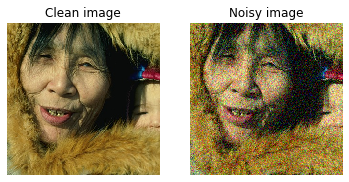

In [4]:
#Builds train and test sets from corresponding repositories
train_set = NoisyBSDSDataset(dataset_root_dir, mode='train')
test_set = NoisyBSDSDataset(dataset_root_dir, mode='test', image_size=(320, 320))
val_set = NoisyBSDSDataset(dataset_root_dir, mode='val', image_size=(320, 320))

#Displays dataset objects created
print(train_set)
print(test_set)
print(val_set)

#Displays 1st image of test set with its noisy version
noisy, clean = test_set[1]
fig, axes = plt.subplots(ncols=2)
myimshow(clean, ax=axes[0])
axes[0].set_title('Clean image')
myimshow(noisy, ax=axes[1])
axes[1].set_title('Noisy image')
plt.show()

## 2 DnCNN



To make our code more versatile, easy to read and save precious coding time, the architecture is going to inherit from the abstract class `NeuralNetwork` of the `nntools` package.


In [5]:
import nntools as nt

A main concept introduced in 'nntools'
is the abstract class 'NeuralNetwork'.
This class describes the general architecture and functionalities that
a neural network object is expected to have.
In particular it has two methods `forward`
and`criterion` used respectively to make a forward pass in the network
and compute the loss.
Open `nntools.py` to inspect its code.
As you can observe these methods are tagged as
_abstract_ and as a result the class is said to be abstract.

An abstract class does not implement all of its methods and cannot
be instantiated.
This is because the implementation of `forward` and `criterion` will
depend on the specific type and architecture of neural networks we
will be considering. The implementation of these two methods will be done
in sub-classes following the principle of inheritance.

For instance, we can define the subclass `NNRegression`
that inherits from `NeuralNetwork`. 

### Question 2
Implement the method
`criterion` as being the cross entropy loss (MSEloss).


In [6]:
class NNRegression(nt.NeuralNetwork):

    def __init__(self):
        super(NNRegression, self).__init__()
        self.regression_loss = nn.MSELoss() #Compute loss as being Mean Squared Error

    def criterion(self, y, d):
        return self.regression_loss(y, d) #Compute loss from output prediction y and target d
    

Compared to `NeuralNetwork`, this class is more specific
as it considers only neural networks that will produce one-hot codes
and that are then classifiers. Nevertheless, this class is still abstract
as it does not implement the method `forward`. Indeed, the method `forward`
depends on the specific architecture of the classification network we will be considering. For denoising we will focus on DnCNN, which has the following architecture

![DnCNN](./dncnn.jpg)


### Question 3
Interpret and complete the following code implementing DnCNN. Refer to PyTorch's documentation for detailed explanations about `nn.ModuleList` and `nn.BatchNorm2d`. Note that in order to preserve the spatial feature dimensions between each successive layer of the network, we will have to use zero-padding by a suitable number of pixels that you have to determine.

In [7]:
#padding = (kernel_size - 1) / 2 
#https://www.aiworkbox.com/lessons/how-to-define-a-convolutional-layer-in-pytorch

class DnCNN(NNRegression):

    def __init__(self, D, C=64, apply_init=True):
        super(DnCNN, self).__init__()
        self.D = D #Number of repetitions
        self.conv = nn.ModuleList() #List of the different modules of our architecture
        
        #Adds the 1st module to the list (Conv 3->64, 3x3)
        self.conv.append(nn.Conv2d(3, C, 3, padding=1))
        
        #Adds the D next modules to the list (Conv 64->64, 3x3)
        for k in range(D):
            self.conv.append(nn.Conv2d(C, C, 3, padding=1))
        
        #Adds the last module to the list (Conv 64->3, 3x3)
        self.conv.append(nn.Conv2d(C, 3, 3, padding=1))
        
        #List containing D times BN (Batch Normalization)
        #BN does not change the shape of the input
        self.bn = nn.ModuleList() 
        for k in range(D):
            self.bn.append(nn.BatchNorm2d(C))

    def forward(self, x):
        D = self.D
        
        #Applies first layer to the input
        h = F.relu(self.conv[0](x))
        
        #Applies Conv + BN + ReLu to the output of previous layer D times
        for k in range(D):
            h = F.relu(self.bn[k] (self.conv[k+1](h))) 
            
        #Applies Conv to the last layer output to get the final output
        #Adds it to the input to denoise it
        y = self.conv[D+1](h) + x
        
        return y

The class `DnCNN`is no longer abstract as it implements all of the methods of its ancestors.



### Training and checkpoints

The package `nntools ` introduces another mechanism
for running learning experiments.
An important aspect when running such an experiment
is to regularly create checkpoints or backups
of the current model, optimization state and statistics
(training loss, validation loss, accuracy, etc).
In case of an unexpected error, you need
to be able to restart the computation from where it stopped and you do not want to rerun everything
from scratch. Typical reasons for your learning to stop are
server disconnection/timeout, out of memory errors, CUDA runtime errors, quota exceeded error, etc.

The computation of statistics will be delegated to the class
`StatsManager `, that provides functionalities to accumulate statistics
from different mini batches and then aggregate/summarize the information
at the end of each epoch.
Read and interpret the code of `StatsManager `.
This class is not abstract since it implements all of its methods.
We could use an instance of this class to monitor the learning
for our classification problem. But this class is too general and then does
not compute classification accuracy. Even though the class is not abstract,
we can still create a subclass by inheritance and redefine some
of its methods, this is called overloading.



 A very classical (but controversial) way to compare the quality of restoration
  techniques is to use the PSNR
  (Peak Signal-to-Noise-Ratio)
  defined for images ranging in $[-1, 1]$ as
  \begin{align}
    \text{PSNR} =
    10 \log_{10} \frac{4 n}{\|y - d\|_2^2}
  \end{align}
  where $d$ is the desired ideal image, $y$ the estimate obtained from $x$ and
  $n$ the number of elements in the tensor.
  The PSNR measures in decibels (dB) the quality of the restoration: the higher the better.
  

### Question 4
Create a new subclass
`DenoisingStatsManager` that inherits from
`StatsManager` and overload each method
  by completing the following code.
This subclass must compute and average PSNR between mini-batches
  (instead of accuracy).



In [8]:
class DenoisingStatsManager(nt.StatsManager):
    
    def __init__(self):
        super(DenoisingStatsManager, self).__init__()

    def init(self):
        super(DenoisingStatsManager, self).init()
        self.running_psnr = 0 

    def accumulate(self, loss, x, y, d):
        super(DenoisingStatsManager, self).accumulate(loss, x, y, d)
        n = y.numel()
        
        #Compute PSNR
        if device == 'cuda':
            self.running_psnr += 10 * np.log10(4 * n / (torch.norm(y.cpu() - d.cpu()))**2) 
        else:
            self.running_psnr += 10 * np.log10(4 * n / (torch.norm(y - d))**2) 
                                           
    def summarize(self):
        loss = super(DenoisingStatsManager, self).summarize()
        psnr = self.running_psnr / self.number_update 
        return {'loss': loss, 'psnr': psnr}

### Testing



Experiments will be carried out by the class `Experiment` which
is defined with respect to 6 inputs
* a given network,
    * a given optimizer,
    * a given training set,
* a given validation set,
    * a given mini batch size,
    * a given statistic manager.

Once instantiated, the experiment can be run for $n$ epochs on the training
set by using the method `run`. The statistics
at each iteration are stored as a list in the attribute `history`.

* An experiment can be evaluated on the validation set by the method \texttt{evaluate}.
    Read the code of that method and
    note that first `self.net` is set to `eval` mode.
    Read the documentation
    \url{https://pytorch.org/docs/stable/nn.html#torch.nn.Module.eval} and
    explain why we use this.
* The `Experiment` class creates a checkpoint at each epoch and automatically restarts
  from the last available checkpoint.
  The checkpoint will be saved into (or loaded from) the directory specified by
  the optional argument _output\_dir_ of the constructor.
  If not specified, a new directory with an arbitrary name is created.
  Take time to read and interpret carefully the code of `Experiment`
  and run the following


<font color="blue">
    
### Eval mode
This mode is set in the evaluation method because it changes the behaviour of the Batch Normalization. Indeed, [documentation](https://pytorch.org/docs/stable/nn.html#torch.nn.BatchNorm2d) says : "*Also by default, during training this layer keeps running estimates of its computed mean and variance, which are then used for normalization during evaluation.*"
This means that BN keeps track of what it computed during training (estimates of it). Then, if `eval` mode is set (at evaluation time here), BN will use these stored values instead of normalizing again from scratch.

</font>

In [16]:
B = 4
D = 6
lr = 1e-3
dncnn = DnCNN(D, apply_init=True) 
dncnn = dncnn.to(device)
adam = torch.optim.Adam(dncnn.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()

#Create the experiment
exp1 = nt.Experiment(dncnn, train_set, val_set, adam, stats_manager, batch_size=B,
                     output_dir="denoising_dncnn", perform_validation_during_training=True)

### Question 5
Check that a directory `denoising1` has been created and inspect its content.
  Explain the file _config.txt_.
  What does the file _checkpoint.pth.tar_ correspond to? Base your answer on Pytorch documentation, `torch.save() ` and `nntools.py`.

Note: Do not try to open checkpoint.pth.tar file in a text editor.


<font color="blue">
    
### Answer
After running the previous code, `denoising1` contains *config.txt* and *checkpoint.pth.tar* files.
The first one looks like this :
```python
Net(DnCNN(
  (regression_loss): MSELoss()
  (conv): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (bn): ModuleList(
    (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
))
TrainSet(NoisyBSDSDataset(mode=train, image_size=(180, 180), sigma=30))
ValSet(NoisyBSDSDataset(mode=val, image_size=(320, 320), sigma=30))
Optimizer(Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
))
StatsManager(DenoisingStatsManager)
BatchSize(4)
PerformValidationDuringTraining(True)
```
* **config.txt**

The first thing described here is our neural network instance (of `DnCNN` class). Value `D` being 6, we can check that our module lists contain the right layers. The first one stores our 8 converters as expected, in the desired order. The other one is made of 6 identical Batch Normalizations.  
Then, both training and evaluation datasets are succefully displayed.  
To finish for the configuration of the experiment, we notice at the end that the `StatsManager` is an instance of the `DenoisingStatsManager` we implemented. We can also check that the batch size is 4 as desired, and that we keep track of estimates during training as explained before.

* **checkpoint.pth.tar**

This file corresponds to the last saved state of the experiment. This state is composed of the state of the neural network, the state of the optimizer and the experiment's `history` attribute (see `Experiment.state_dict()` method). The states of the neural network and the optimizer are retrieved from their `state_dict()` method, provided by **PyTorch**, since they are `torch.nn.Module`([documentation](https://pytorch.org/docs/stable/nn.html#torch.nn.Module.state_dict)).  
This state is saved on disk with the `Experiment.save()` method. `save()` does two things : 
1. Saves the current state by using `torch.save()` given `state_dict()` and the checkpoint file path. `save()` serializes a Python object to store it in a disk file. This object can be then retrieved from the file with the `torch.load()`.
2. Prints the experiment's current settings in the configuration file

So, to answer the question, the *checkpoint.pth.tar* corresponds to the `state_dict` object of the experiment.

</font>

### Question 6

Run the experiment for 20 epochs by executing the following code. Your function  should display at every $visu\_rate$ epochs
something similar to the results given here after.
 If it does not, interrupt it, 
check your code, delete the `output_dir`,
and start again.


Start/Continue training from epoch 0
Epoch 1 (Time: 4.25s)
Epoch 2 (Time: 4.25s)
Epoch 3 (Time: 4.19s)
Epoch 4 (Time: 4.33s)
Epoch 5 (Time: 4.23s)
Epoch 6 (Time: 4.30s)
Epoch 7 (Time: 4.37s)
Epoch 8 (Time: 4.20s)
Epoch 9 (Time: 4.30s)
Epoch 10 (Time: 4.26s)
Epoch 11 (Time: 4.30s)
Epoch 12 (Time: 4.26s)
Epoch 13 (Time: 4.20s)
Epoch 14 (Time: 4.26s)
Epoch 15 (Time: 4.37s)
Epoch 16 (Time: 4.22s)
Epoch 17 (Time: 4.34s)
Epoch 18 (Time: 4.23s)
Epoch 19 (Time: 4.20s)
Epoch 20 (Time: 4.28s)
Finish training for 20 epochs


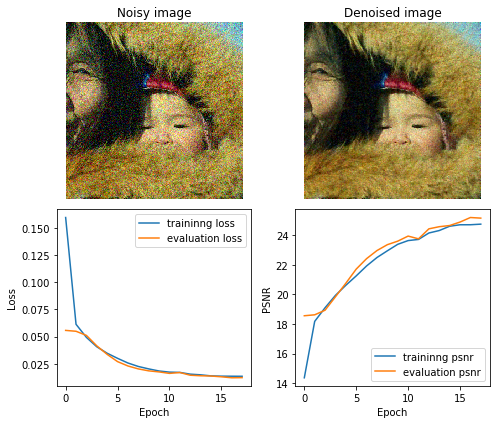

In [17]:
def plot(exp, fig, axes, noisy, visu_rate=3):
    if exp.epoch % visu_rate != 0:
        return
    with torch.no_grad():
        denoised = exp.net(noisy[np.newaxis].to(exp.net.device))[0]
    axes[0][0].clear()
    axes[0][1].clear()
    axes[1][0].clear()
    axes[1][1].clear()
    myimshow(noisy, ax=axes[0][0])
    axes[0][0].set_title('Noisy image')
    myimshow(denoised, ax=axes[0][1])
    axes[0][1].set_title('Denoised image')    
    axes[1][0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)], label="traininng loss")
    axes[1][1].plot([exp.history[k][0]['psnr'] for k in range(exp.epoch)], label="traininng psnr")
    axes[1][0].plot([exp.history[k][1]['loss'] for k in range(exp.epoch)], label="evaluation loss")
    axes[1][1].plot([exp.history[k][1]['psnr'] for k in range(exp.epoch)], label="evaluation psnr")
    axes[1][0].legend()
    axes[1][0].set_xlabel("Epoch")
    axes[1][0].set_ylabel("Loss")        
    axes[1][1].legend()
    axes[1][1].set_xlabel("Epoch")
    axes[1][1].set_ylabel("PSNR")    
    plt.tight_layout()
    fig.canvas.draw()
    
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(7,6))
exp1.run(num_epochs=20, plot=lambda exp: plot(exp, fig=fig, axes=axes, noisy=test_set[1][0]))

<font color="blue">

### Note
Execution on CPU takes approximately 30 seconds per epoch, whereas on GPU it takes around 4 seconds.

### Graphical Interpretation
To begin with, the network does its job *i.e.* the **Loss** decreases at each epoch and **PSNR** is increasing until $24$.
So we are obviously getting a better image at each epoch, both for training and evaluation.
Two images are identical if the MSE loss is zero, and we can notice here that it is getting closer and closer to the zero value.  
To finish, evaluation loss and PSNR values are really close to the training ones. The evaluation loss starts at a way lower value than the training one, and in the same idea, the PNSR starts at a higher value than in training. This is due to the use of the `eval` mode of the network for evaluation, it uses the estimates computed during training to go faster and just propagate the validation set through the network (without backpropagation). That's why the values we get are close to the training and the evolution is faster.

### Question 7
Compare the noisy, clean and denoised results on a few images of the testing set. Evaluate the visual quality of your result.
Do you see any artifacts or loss of information?


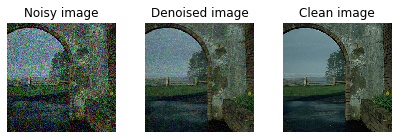

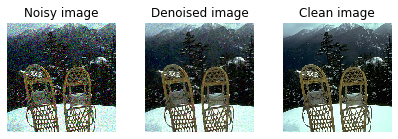

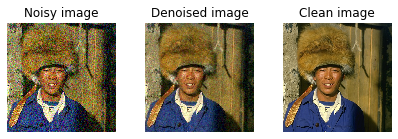

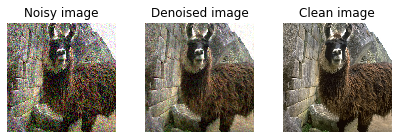

In [11]:
test_loader = td.DataLoader(test_set, batch_size=B, shuffle=True,
                            drop_last=True, pin_memory=True)
_, sample = next(enumerate(test_loader))
noisy, clean = sample
clean = clean.to(device)
noisy = noisy.to(device)
with torch.no_grad():
    denoised = dncnn(noisy)
for k in range(clean.shape[0]):
    fig, axis = plt.subplots(ncols=3, figsize=(7,2), sharex='all', sharey='all')
    myimshow(noisy[k], ax=axis[0])
    axis[0].set_title('Noisy image')
    myimshow(denoised[k], ax=axis[1])
    axis[1].set_title('Denoised image')
    myimshow(clean[k], ax=axis[2])
    axis[2].set_title('Clean image')
    plt.show()

<font color="blue">
    
### Results analysis
With these four images, we will try to evaluate the quality obtained with our denoising neural network.  
Firstly, we easily see the difference between noisy and denoised images. If we don't look at it too closely, the denoised image seems to have just a few noise left on it for each example.  
Indeed, denoised and clean images, at first, look pretty similar compared to the noisy one.  
Moreover, it is hard to notice any loss of information or any artifact. It is possible that the Neural Network simply replaces pixels identified as noise by one with the color of surrounding pixels. 
The only thing that we can see is some noise remaining when looking at the images from closer. Indeed, the network successfully removed noisy pixels with a very different color from the one on the target image, but we see that the noise remaining is nearly the same color as the desired pixels.  
To conclude, **the closer the noise's color is to the desired one, the harder it is for the network to identify it as noise and so remove it**. 

</font>

### Question 8
What is the number of parameters of DnCNN(D)? What is the receptive field of DnCNN(D), i.e,how many input pixels do influence an output pixel?

Denoising literature claims that for reducing Gaussian noise of standard
  deviation $\sigma=30$ efficiently, a pixel should be influenced by
  at least $33 \times 33$ pixels. How large $D$ (how deep) should
  DnCNN be to satisfy this constraint? What would be the implication on
  the number of parameters and the computation time?



<font color="blue">

### Answer

* **Parameters**

To compute the number of parameters of our whole network, we need to sum the parameters for each layer.
The first convolutionnal layer has kernel size $3x3$, 3 channels and will create 64 channels. Adding the bias, we get this formula for its number of parameters : $(3*3*3+1) * 64 = 1792$   
Then, the kernel size stays the same for the whole architecture.      
For each layer in the middle, we get : $(3*3*64+1) * 64 = 36928$  
For the last convolution, the number of parameters is : $(3*3*64+1) * 3 = 1731$  
**So the number of parameters of DnCNN(D) is** $1792 + D*36928 + 1731 = D*36 928 + 3523$.  
In the previous example, with $D = 6$, this gives a total number of parameters of $225 091$.  

* **Receptive field**

To begin, the kernel size of each of our convolutionnal layers is $3 \times 3$, so the receptive field for one layer is $9$.
Our architecture is compose of $2$ different convolutionnal layers, one at the beginning and the other at the end. Between them, there are D others.  
So the formula to get the number of pixels that influence $1$ pixel on the output is in our case : $(1 + (D+2) * 2)^2$. Indeed, we have at first 1 pixel, and then for each convolution we add the surrounding pixel, *i.e.* $2$ for width and $2$ for height.    
For our previous example, $D$ was set to $6$ so the receptive field was $17 \times 17$ pixels.

* **Influence of depth on memory**

To match the given constraint, the network should have a depth of $D = 14$. We tried to launch this on GPU but it didn't work because of a lack of memory. That's why a deeper network obviously increases memory used and also computation time.
Nevertheless, this increase is only **linear**, both for computation time and memory used. This is due to the fact that parameters increase linearly to $D$ as it is shown is the parameters number formula, and adding a convolution only adds 1 iteration to the `forward` method of the neural network.

For example, trying with $D = 10$ gave use a compute time of about 6-7 seconds per epoch, instead of 4 seconds with $D = 6$.

The fact that depth influence on performance and memory is only linear is an asset of CNNs and Deep Learning.

</font>

## 3 U-net like CNNs
Pooling layers allows us to increase the receptive field
without making the network deeper and slower. But
pooling layers lose spatial resolution.
In order to retrieve the spatial dimension we will have to use unpooling.
Our architecture will resemble the so-called U-net architecture
(that was originally introduced for image segmentation).
Our network will consist of a contracting path and an expansive path,
which gives it the U-shaped architecture. The contracting path is
a typical convolutional network that consists of repeated application
of convolutions, ReLU and max pooling operation. During the contraction,
the spatial information is reduced.
The expansive pathway reconstructs spatial information through a sequence of
unpooling and convolutions (note that if we were using strided convolutions, we
would have to use transpose convolutions), and combined
high-resolution features from the contracting path.
In the original U-net, features were combined by concatenating the channels
of the tensors, but here we will consider their sum divided by $\sqrt{2}$
(this is to preserve the range of feature variations).
The architecture is summarized in the following scheme. 



![DnCNN](./udncnn.jpg)

### Question 9
Complete the following code to implement this architecture.

In [12]:
class UDnCNN(NNRegression):

    def __init__(self, D, C=64):
        super(UDnCNN, self).__init__()
        self.D = D #Depth of the network
        
        #List containing our convolutionnal modules
        self.conv = nn.ModuleList()
        
        #List containing D times BN (Batch Normalization)
        self.bn = nn.ModuleList()
        
        #Add 1st module to the list (Conv 3->64 3x3)
        self.conv.append(nn.Conv2d(3, C, 3, padding=1))
        
        #Fill Conv and BN lists
        for k in range(D):
            self.conv.append(nn.Conv2d(C, C, 3, padding=1))
            self.bn.append(nn.BatchNorm2d(C))
               
        #Add last module to the list (Conv 64->3 3x3)
        self.conv.append(nn.Conv2d(C, 3, 3, padding=1))
                

    def forward(self, x):
        D = self.D
        
        h = [None] * int(D + 1) #outputs of each layer
        i = [None] * int(D/2-1) #indices for unpooling
        s = [None] * int(D/2-1) #shape of each output in contracting pathway
        
        h[0] = F.relu(self.conv[0](x)) #First convolution
        
        ###Begin contracting pathway
        for k in range(int(D/2)-1):
            h[k+1] = F.relu(self.bn[k] (self.conv[k+1] (h[k]))) #Apply conv + BN + ReLU
            s[k] = h[k+1].shape #needed for unpool layers
            h[k+1], i[k] = F.max_pool2d(h[k+1], (2,2), return_indices=True) #Apply pooling and store indices for unpooling
        
        #Last layer of contracting pathway
        k = int(D/2) - 1
        h[k+1] = F.relu(self.bn[k] (self.conv[k+1] (h[k]))) #Only apply Conv + BN + ReLU
        k = int(D/2)
        
        ###Begin expansive pathway
        
        #First layer of expansive pathway
        h[k+1] = F.relu(self.bn[k] (self.conv[k+1](h[k]))) #Only apply Conv + BN + ReLU
        h[k+1] = (h[k+1] + h[k-1]) / np.sqrt(2) #Apply the first sum operation of the network
        
                        
        for k in range(int(D/2)+1, D):
            l = D - k - 1 #index of the corresponding layer in contracting pathway
            h[k] = F.max_unpool2d(h[k], i[l], (2,2), output_size=s[l]) #Apply unpool with the right stored indices and size
            h[k+1] = F.relu(self.bn[k] (self.conv[k+1] (h[k]))) #Then apply Conv + BN + ReLU
            h[k+1] = (h[k+1] + h[l]) / np.sqrt(2) #Apply the sum with the corresponding contracting layer output
                        
        y = self.conv[D + 1](h[D]) + x
        
        return y

### Question 10
Test it this architecture and analyze the result

Start/Continue training from epoch 0
Epoch 1 (Time: 2.59s)
Epoch 2 (Time: 2.62s)
Epoch 3 (Time: 2.70s)
Epoch 4 (Time: 2.64s)
Epoch 5 (Time: 2.61s)
Epoch 6 (Time: 2.72s)
Epoch 7 (Time: 2.62s)
Epoch 8 (Time: 2.67s)
Epoch 9 (Time: 2.64s)
Epoch 10 (Time: 2.66s)
Epoch 11 (Time: 2.64s)
Epoch 12 (Time: 2.67s)
Epoch 13 (Time: 2.56s)
Epoch 14 (Time: 2.64s)
Epoch 15 (Time: 2.59s)
Epoch 16 (Time: 2.64s)
Epoch 17 (Time: 2.58s)
Epoch 18 (Time: 2.59s)
Epoch 19 (Time: 2.59s)
Epoch 20 (Time: 2.64s)
Finish training for 20 epochs


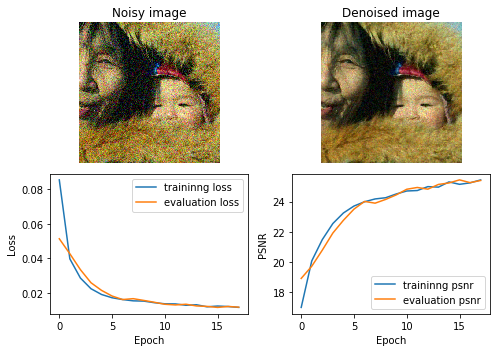

In [18]:

B = 4
D = 6
lr = 1e-3
udncnn = UDnCNN(D)
udncnn = udncnn.to(device)
adam = torch.optim.Adam(udncnn.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()

#Create he second experiment
exp2 = nt.Experiment(udncnn, train_set, val_set, adam, stats_manager, batch_size=B,
                     output_dir="denoising_udncnn", perform_validation_during_training=True)

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(7,5))
exp2.run(num_epochs=20, plot=lambda exp: plot(exp, fig=fig, axes=axes, noisy=test_set[1][0]))

### Note
We notice here that this network is, as expected, faster than the **DnCNN** for the same depth. Here it takes 2 seconds per epoch for $D = 6$, whereas the previous network took around 4 seconds per epoch. (everything on GPU here)

### Graphical interpretation
We chose to run this architecture on $20$ epochs to make a comparison with the previous one.  
As the previous network, we see that the loss is decreasing at each epoch, and it is getting closer to zero.  
The PSNR is increasing up to $26$, which a little better than for **DnCNN**.  
The loss is a little lower than before, but it is also not that significant.  

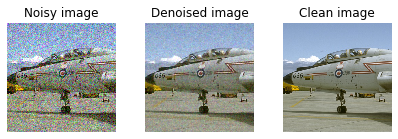

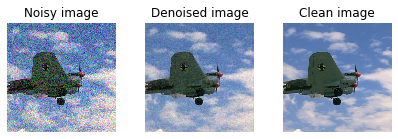

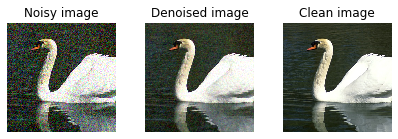

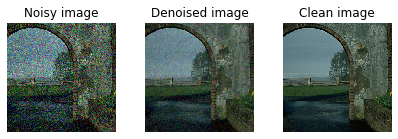

In [14]:
test_loader = td.DataLoader(test_set, batch_size=B, shuffle=True,
                            drop_last=True, pin_memory=True)
_, sample = next(enumerate(test_loader))
noisy, clean = sample
clean = clean.to(device)
noisy = noisy.to(device)
with torch.no_grad():
    denoised = udncnn(noisy)
for k in range(clean.shape[0]):
    fig, axis = plt.subplots(ncols=3, figsize=(7,2), sharex='all', sharey='all')
    myimshow(noisy[k], ax=axis[0])
    axis[0].set_title('Noisy image')
    myimshow(denoised[k], ax=axis[1])
    axis[1].set_title('Denoised image')
    myimshow(clean[k], ax=axis[2])
    axis[2].set_title('Clean image')
    plt.show()

### Results Analysis
The visual results look the same as the **DnCNN**'s results, *i.e.* the quality of the denoised images is way better than the noisy ones but there is still noise remaining as explained before. We can't really see it but we should observe here some loss of information due to the unpooling: "*MaxUnpool2d takes in as input the output of MaxPool2d including the indices of the maximal values and computes a partial inverse in which all non-maximal values are set to zero.*" ([documentation](https://pytorch.org/docs/stable/nn.html#torch.nn.MaxUnpool2d)). 

### Question 11
What is its number of parameters and the receptive field ?

### Answer

* **Parameters**

As for the previous network, to compute the total number of paramaters we will have to sum the number of paramters of each layer.  
We have the same values for the convolutionnal layers at the extremities, *i.e.* $1792 + 1731 = 3523$.  
Then, since a pooling layer doesn't learn any parameter (only replaces a square of pixels by its max value), our number of parameters finally stays the same as for **DnCNN** because only convolutionnal layers learn parameters in our architecture.

That's why we get again this number of parameters (convolutionnal layers stayed unchanged): $D*36 928 + 3523$.

* **Receptive field**

A pooling of size $2 \times 2$ like we use doubles the receptive field. An unpooling of same kernel size cancels this effect. So, for a given module in the architecture, we have this formula for the receptive field : $2^{(p-u)}$ with $p$ the number of poolings done so far and $u$ the same for unpoolings. To this, we need to had the effect of convolution on the receptive field. As we saw in question $8$, a $3 \times 3$ convolution just adds $2$ pixels for each dimension. The formula becomes : $2^{(p-u+1)}$, the $+1$ standing for convolution effect.  
Let's now compute the final receptive field value for our network with the previous formula applied to each module of the architecture. To make it easy to understand, we will keep the values in the same order as in the formula *i.e.* $(p-u+1)$.
We start with $1$ pixel as before, so the first convolution gives $1 + 2^{(0-0+1)}$. Then we have the first *convolution + pooling* module giving $2^{(1-0+1)}$. For the following one it is the same, adding a pooling : $2^{(2-0+1)}$.
The two modules in the middle give : $2^{(2-0+1)}*2$.
Then we can go through the expansive pathway. The first module has $2^{(2-1+1)}$ for receptive field size. The next one $2^{(2-2+1)}$.
And finally the last convolution gives also $2^{(2-2+1)}$ since no more pooling and unpooling have been done.  
Summing all this we obtain a receptive field of : $1+2+4+8+2*8+4+2+2=39$. A pixel in the output is influenced by $39 \times 39$ pixels of the input image. 

This verifies that **U-net like** architecture allows us to significantly increase receptive field without making the network deeper and impacting computing speed. This only cons of this method is explained by the note below, we lose information with pooling.







_Note : Though pooling layers
increase the receptive field, they lose information about exact locations.
This is desired for classification, but for denoising this decreases performance.
An alternative to pooling is to use dilated convolutions
(sometimes refer to the {\it \`a trous} algorithm, meaning {\it with holes}).
Instead of increasing the receptive field by reducing the feature spatial
dimensions by a factor 2 after each convolution, the filters are dilated
by a factor 2. _